### Job Change Prediction

##### Context
An Ed-Tech company wants to hire data scientists among people who have successfully passed some courses and then signed up for training. The company wants to know which of the people are looking for a job change and will prefer working with them after completion of training because it helps to reduce the cost and time for categorization of candidates.

Information related to demographics, education, the experience is in hands from candidates sign up and enrollment.

### Data Description
- enrollee_id: Unique ID for the candidate
- city: City code
- city_ development _index: Development index of the city (scaled)
- gender: Gender of the candidate
- relevent_experience: Relevant experience of the candidate
- enrolled_university: Type of University course enrolled if any
- education_level: Education level of candidate
- major_discipline: Education major discipline of the candidate
- experience: Candidate total experience in years
- company_size: No of employees in current employer's company
- company_type: Type of current employer
- lastnewjob: Difference in years between previous job and current job
- training_hours: training hours completed
- target: 0 – Not looking for a job change, 1 – Looking for a job change



### Importing Libraries

In [41]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metrics scores and split data
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score, 
    accuracy_score, 
    precision_score,
    confusion_matrix,
    roc_auc_score,
    recall_score
)

# To impute missing values
from sklearn.impute import KNNImputer

# To bin cotinuous data into intervals
from sklearn.preprocessing import KBinsDiscretizer

# To build a logistic regression model
from sklearn.linear_model import LogisticRegression

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler



In [2]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 10.8 MB/s eta 0:00:00


### Loading Data

In [4]:
data = pd.read_csv('jobs_data.csv')
df = data.copy()
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [5]:
df.shape

(19158, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

- Only 4 variables are numerical rest all are object types
- 8 columns have less than 19158 non-null values i.e. columns have missing values

In [7]:
df.duplicated().sum()

0

In [8]:
round(df.isnull().sum()/df.isnull().count() *100, 2)

enrollee_id                0.00
city                       0.00
city_development_index     0.00
gender                    23.53
relevent_experience        0.00
enrolled_university        2.01
education_level            2.40
major_discipline          14.68
experience                 0.34
company_size              30.99
company_type              32.05
last_new_job               2.21
training_hours             0.00
target                     0.00
dtype: float64

- company_type column has 32.05% missing values out of the total observations.
- company_size column has 30.99% missing values out of the total observations.
- gender column has 23.53% missing values out of the total observations.
- major_discipline column has 14.68% missing values out of the total observations.
- education_level column has 2.40% missing values out of the total observations.
- last_new_job column has 2.21% missing values out of the total observations.
- enrolled_university column has 2.01% missing values out of the total observations.
- experience column has 0.34% missing values out of the total observations.
- We will impute these values after we split the data into train, validation and test sets.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
enrollee_id,19158.0,16875.358179,9616.292592,1.000,8554.25,16982.500,25169.75,33380.000
city_development_index,19158.0,0.828848,0.123362,0.448,0.74,0.903,0.92,0.949
training_hours,19158.0,65.366896,60.058462,1.000,23.00,47.000,88.00,336.000
target,19158.0,0.249348,0.432647,0.000,0.00,0.000,0.00,1.000


### Observations

- enrollee_id: enrollee_id being a unique identifier doesn't add any meaning to the analysis and can be dropped.
- city_developement_index: Since the value of the city development index is normalized a 0.82 average value indicates that most of the data we have is from fairly developed cities (metropolitan cities). However, the range of the index is large and varies from 0.448 to 0.949.
- training_hours: Training hours have a wide range from 60hrs to 336hrs. On average, an enrollee has 65hrs of training. 755 of the enrollees less than (or equal to) 88hrs of training.
- target: 75% of the enrollees in data are not looking for a job and maybe they just signed up to get trained in new technologies

In [10]:
col = df.columns
for column in col:
    print(df[column].value_counts(normalize=True))
    print("--"*50)

8949     0.000052
10660    0.000052
30726    0.000052
18507    0.000052
31273    0.000052
           ...   
11547    0.000052
32067    0.000052
14356    0.000052
18051    0.000052
23834    0.000052
Name: enrollee_id, Length: 19158, dtype: float64
----------------------------------------------------------------------------------------------------
city_103    0.227320
city_21     0.141038
city_16     0.080019
city_114    0.069736
city_160    0.044107
              ...   
city_129    0.000157
city_111    0.000157
city_121    0.000157
city_140    0.000052
city_171    0.000052
Name: city, Length: 123, dtype: float64
----------------------------------------------------------------------------------------------------
0.920    0.271427
0.624    0.141038
0.910    0.080019
0.926    0.069736
0.698    0.035651
           ...   
0.649    0.000209
0.807    0.000209
0.781    0.000157
0.625    0.000157
0.664    0.000052
Name: city_development_index, Length: 93, dtype: float64
-------------------------

### Data Preprocessing 

In [11]:
df.drop(['enrollee_id'], axis=1, inplace=True)


- We will do missing value imputation after splitting the data into train, test and validation to avoid data leakage

In [12]:
df['target'].replace(1,'Yes', inplace = True)
df['target'].replace(0, 'No', inplace=True)

#### Data Cleaning

Drop "enrollee_id" as "enrollee_id" is unique for each candidate and might not add value to modeling.
Missing value imputation will be done after splitting the data.

### Feature Engineering

In [13]:
df['city'].nunique()

123

There are 123 cities in data, we can reduce the levels by grouping them into 3 major categories
- Developed city: with city development index greater than 0.90
- Developing city: with city development index b/w 0.74 and 0.90
- Under developed city: with city development index b/w 0.4 and 0.74

we will bin the data after splitting into train/test/val to avoid data leakage

In [14]:
df['city_development_index'].describe()

count    19158.000000
mean         0.828848
std          0.123362
min          0.448000
25%          0.740000
50%          0.903000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64

### Missing-Value treatment

- we will use KNN imputer to impute missing values
- KNNImputer: each samples missing values are imputed by looking at the n_neighbors nearest neighbors found in the training set. Default value for n_neighbors =5
- KNN imputer replaces missing values using the average of k nearest non-missing feature values
- Nearest points are found based on euclidean distance

In [15]:
df.isnull().sum()

city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [16]:
# defining a list with names of columns that will be used for imputation
reqd_col_for_impute = ["gender", "enrolled_university", "education_level", "major_discipline", "experience", "company_size", "company_type", "last_new_job" ]

In [17]:
df[reqd_col_for_impute].head()

,gender,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,Male,no_enrollment,Graduate,STEM,>20,NaN,NaN,1
1,Male,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4
2,NaN,Full time course,Graduate,STEM,5,NaN,NaN,never
3,NaN,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never
4,Male,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4


In [18]:
data1 = df.copy()

In [19]:
# we need to pass numerical values for each categorical column for KNN imputation so we will lable encode them

gender = {"Male": 0, "Female": 1, "Other": 2}
data1['gender'] = data1['gender'].map(gender)

enrolled_university = {"no_enrollment": 0, "Full time course": 1, "Part time course": 2}
data1["enrolled_university"] = data1["enrolled_university"].map(enrolled_university)

education_level = {
    "Graduate": 0,
    "Masters": 1,
    "High School": 2,
    "Phd": 3,
    "Primary School": 4,
}
data1["education_level"] = data1["education_level"].map(education_level)

major_discipline = {
    "STEM": 0,
    "Business Degree": 1,
    "Arts": 2,
    "Humanities": 3,
    "No Major": 4,
    "Other": 5,
}
data1["major_discipline"] = data1["major_discipline"].map(major_discipline)

experience = {
    "<1": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 7,
    "8": 8,
    "9": 9,
    "10": 10,
    "11": 11,
    "12": 12,
    "13": 13,
    "14": 14,
    "15": 15,
    "16": 16,
    "17": 17,
    "18": 18,
    "19": 19,
    "20": 20,
    ">20": 21,
}
data1["experience"] = data1["experience"].map(experience)

company_type = {
    "Pvt Ltd": 0,
    "Funded Startup": 1,
    "Early Stage Startup": 2,
    "Other": 3,
    "Public Sector": 4,
    "NGO": 5,
}
data1["company_type"] = data1["company_type"].map(company_type)

company_size = {
    "<10": 0,
    "10/49": 1,
    "100-500": 2,
    "1000-4999": 3,
    "10000+": 4,
    "50-99": 5,
    "500-999": 6,
    "5000-9999": 7,
}
data1["company_size"] = data1["company_size"].map(company_size)

last_new_job = {"never": 0, "1": 1, "2": 2, "3": 3, "4": 4, ">4": 5}
data1["last_new_job"] = data1["last_new_job"].map(last_new_job)


In [20]:
data1.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,0.0,Has relevent experience,0.0,0.0,0.0,21.0,NaN,NaN,1.0,36,Yes
1,city_40,0.776,0.0,No relevent experience,0.0,0.0,0.0,15.0,5.0,0.0,5.0,47,No
2,city_21,0.624,NaN,No relevent experience,1.0,0.0,0.0,5.0,NaN,NaN,0.0,83,No
3,city_115,0.789,NaN,No relevent experience,NaN,0.0,1.0,0.0,NaN,0.0,0.0,52,Yes
4,city_162,0.767,0.0,Has relevent experience,0.0,1.0,0.0,21.0,5.0,1.0,4.0,8,No


- Values have been encoded

#### Data Preparation for Modeling

In [21]:
x = data1.drop(['target'], axis=1)
y = data1['target'].apply(lambda x : 1 if x == 'Yes' else 0)


In [22]:
# splitting dataset into training, validation and test set

x_temp, x_test, y_temp, y_test = train_test_split(x,y, test_size= 0.2, random_state=1, stratify=y)

# split temp data into train and validation

x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size = 0.25, random_state=1, stratify= y_temp)


print(x_train.shape, x_val.shape, x_test.shape)

(11494, 12) (3832, 12) (3832, 12)



KBinsDiscretizer() is helpful in binning the continuous variable.Based on the city development index, we will group the data as under developed city, developing city and developed city. We need to first sort the development index values and create 3 bins so that we can classify the city value as under developed city, developing city and developed city.
KBinsDiscretizer() has the following parameters :

n_bins: The number of bins to produce
encode{‘onehot’, ‘onehot-dense’, ‘ordinal’}: Method used to encode the transformed result We will use "ordinal" as it return the bin identifier encoded as an integer value.
strategy{‘uniform’, ‘quantile’, ‘kmeans’}: Strategy used to define the widths of the bins. We will use "quantile" method as we need to sort the data and create bins.
To avoid data leakage, we will process the data after splitting, fit_transform the method on train set and then transform it to validation and train set.

In [23]:
bins_transform = KBinsDiscretizer(n_bins=3, encode ="ordinal", strategy ="quantile")
x_train["city"] = bins_transform.fit_transform(np.array(x_train["city_development_index"]).reshape(-1,1))

x_val['city'] = bins_transform.transform(np.array(x_val["city_development_index"]).reshape(-1,1))
x_test['city'] = bins_transform.transform(np.array(x_test["city_development_index"]).reshape(-1,1))

In [24]:
labels = {0: "Under_Developed", 1: "Developing", 2: "Developed"}
x_train["city"] = x_train["city"].map(labels)
x_val["city"] = x_val["city"].map(labels)
x_test["city"] = x_test["city"].map(labels)

### Imputing missing values

In [25]:
imputer = KNNImputer(n_neighbors=5)


In [26]:
x_train[reqd_col_for_impute] = imputer.fit_transform(x_train[reqd_col_for_impute])

x_val[reqd_col_for_impute] = imputer.transform(x_val[reqd_col_for_impute])
x_test[reqd_col_for_impute] = imputer.transform(x_test[reqd_col_for_impute])

In [29]:
print(x_train.isna().sum())
print("---"*30)
print(x_val.isna().sum())
print("---"*30)
print(x_test.isna().sum())

city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64
------------------------------------------------------------------------------------------
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64
------------------------------------------------------------------------------------------
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled

In [30]:
## function to inverse the encoding

def inverse_mapping(x,y):
    inv_dict = {v:k for k,v in x.items()}
    x_train[y] = np.round(x_train[y]).map(inv_dict).astype("category")
    x_val[y] = np.round(x_val[y]).map(inv_dict).astype("category")
    x_test[y] = np.round(x_test[y]).map(inv_dict).astype("category")

In [31]:
inverse_mapping(gender, "gender")
inverse_mapping(enrolled_university, "enrolled_university")
inverse_mapping(education_level, "education_level")
inverse_mapping(major_discipline, "major_discipline")
inverse_mapping(experience, "experience")
inverse_mapping(company_size, "company_size")
inverse_mapping(company_type, "company_type")
inverse_mapping(last_new_job, "last_new_job")

- Checking inverse mapped values/categories.

In [32]:
cols = x_train.select_dtypes(include=["object","category"])
for i in cols.columns:
    print(x_train[i].value_counts())
    print("*"*30)

Developed          4608
Under_Developed    3685
Developing         3201
Name: city, dtype: int64
******************************
Male      10545
Female      835
Other       114
Name: gender, dtype: int64
******************************
Has relevent experience    8274
No relevent experience     3220
Name: relevent_experience, dtype: int64
******************************
no_enrollment       8445
Full time course    2340
Part time course     709
Name: enrolled_university, dtype: int64
******************************
Graduate          7060
Masters           2761
High School       1245
Phd                245
Primary School     183
Name: education_level, dtype: int64
******************************
STEM               9805
Business Degree     706
Humanities          391
Arts                248
Other               220
No Major            124
Name: major_discipline, dtype: int64
******************************
>20    1977
4       846
5       838
3       811
6       744
2       679
7       627
9      

In [33]:
cols = x_val.select_dtypes(include=["object","category"])
for i in cols.columns:
    print(x_val[i].value_counts())
    print("--"*30)

Developed          1575
Under_Developed    1211
Developing         1046
Name: city, dtype: int64
------------------------------------------------------------
Male      3540
Female     253
Other       39
Name: gender, dtype: int64
------------------------------------------------------------
Has relevent experience    2784
No relevent experience     1048
Name: relevent_experience, dtype: int64
------------------------------------------------------------
no_enrollment       2787
Full time course     800
Part time course     245
Name: enrolled_university, dtype: int64
------------------------------------------------------------
Graduate          2336
Masters            929
High School        423
Phd                 88
Primary School      56
Name: education_level, dtype: int64
------------------------------------------------------------
STEM               3261
Business Degree     225
Humanities          136
Arts                 93
Other                68
No Major             49
Name: major_

In [34]:
cols = x_test.select_dtypes(include=["object","category"])
for i in cols.columns:
    print(x_test[i].value_counts())
    print("--"*30)

Developed          1554
Under_Developed    1245
Developing         1033
Name: city, dtype: int64
------------------------------------------------------------
Male      3478
Female     316
Other       38
Name: gender, dtype: int64
------------------------------------------------------------
Has relevent experience    2734
No relevent experience     1098
Name: relevent_experience, dtype: int64
------------------------------------------------------------
no_enrollment       2809
Full time course     779
Part time course     244
Name: enrolled_university, dtype: int64
------------------------------------------------------------
Graduate          2329
Masters            920
High School        423
Phd                 91
Primary School      69
Name: education_level, dtype: int64
------------------------------------------------------------
STEM               3206
Business Degree     229
Humanities          158
Arts                 96
Other                93
No Major             50
Name: major_

### Creating Dummy Variables

In [35]:
x_train = pd.get_dummies(x_train, drop_first=True)
x_val = pd.get_dummies(x_val, drop_first=True)
x_test = pd.get_dummies(x_test, drop_first=True)

print(x_train.shape, x_val.shape, x_test.shape)

(11494, 56) (3832, 56) (3832, 56)


### Building the model
#### Model evaluation criterion:
##### Model can make wrong predictions as:
- Predicting an enrollee is looking for a job change but in reality, the enrollee is not looking for a change - Loss of resources
- Predicting an enrollee is not looking for a job change but the enrollee is looking for a job change - Loss of opportunity
##### Which case is more important?
- Predicting an enrollee is not looking for a job change but the enrollee is looking for a job change i.e. losing on a potential candidate as the candidate will not be targeted by the HR team when he should be targeted.
##### How to reduce this loss i.e need to reduce False Negatives?
- Company would want Recall to be maximized, greater the Recall lesser the chances of false negatives.

In [36]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [37]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Logistic Regression

In [38]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

### Let's evaluate the model performance by using KFold and cross_val_score

K-Folds cross-validation provides dataset indices to split data into train/validation sets. Split dataset into k consecutive stratified folds (without shuffling by default). Each fold is then used once as validation while the k - 1 remaining folds form the training set.

Stratified K-fold is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

Note - We will check the cross-validated performance on train set set only for this model (logistic regression with original set) to demonstrate Stratified K-fold. Since we have sufficient amount of data to split the data into three sets, we will not used K-fold for any other model, instead we will train the model using train set, assess the performance on validation set and use test set only for the final model.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

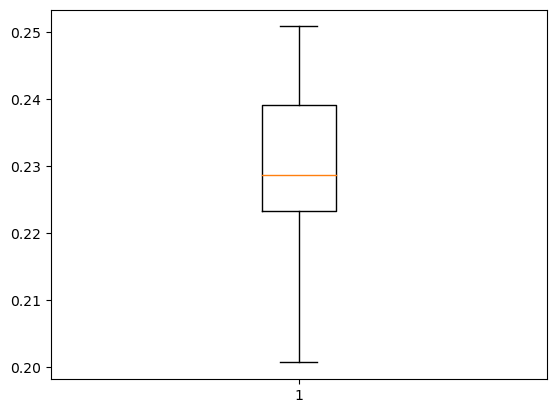

In [39]:
scoring = 'recall'
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_result_bfr = cross_val_score(estimator=lr, X=x_train, y=y_train, scoring=scoring, cv=kfold)
plt.boxplot(cv_result_bfr)
plt.show()

In [42]:
# Calculating different metrics on train set
log_reg_model_train_perf = model_performance_classification_sklearn(
    lr, x_train, y_train
)
print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.762137,0.224006,0.557292,0.319562


In [43]:
# Calculating different metrics on validation set
log_reg_model_val_perf = model_performance_classification_sklearn(lr, x_val, y_val)
print("Validation performance:")
log_reg_model_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.761482,0.245816,0.549065,0.339595


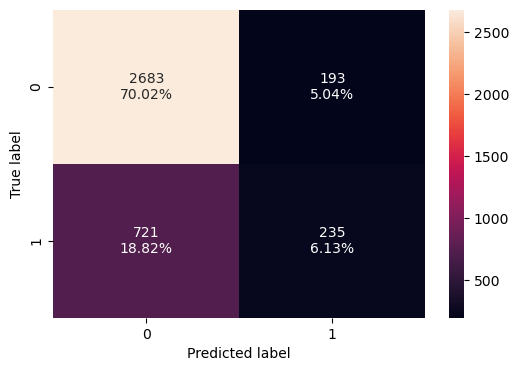

In [44]:
# creating confusion matrix
confusion_matrix_sklearn(lr, x_val, y_val)

- Logistic Regression has given a similar performance on training and validation set.
- Recall is very low, we can try oversampling (increase training data) to see if the model performance can be improved.

### Oversampling train data using SMOTE

In [47]:
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train ==1)))
print("Before Oversampling, counts of label 'No': {}".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
x_train_over, y_train_over = sm.fit_resample(x_train, y_train)

print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of train_X: {}".format(x_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 2866
Before Oversampling, counts of label 'No': 8628
After Oversampling, counts of label 'Yes': 8628
After Oversampling, counts of label 'No': 8628 

After Oversampling, the shape of train_X: (17256, 56)
After Oversampling, the shape of train_y: (17256,) 



### Logistic Regression on oversampled data

In [48]:
log_reg_over = LogisticRegression(random_state=1)
log_reg_over.fit(x_train_over, y_train_over)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

Let's check the model performance on train and validation set

In [49]:
# Calculating different metrics on train set
log_reg_over_train_perf = model_performance_classification_sklearn(
    log_reg_over, x_train_over, y_train_over
)
print("Training performance:")
log_reg_over_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.806734,0.76866,0.832016,0.799084


In [50]:
# Calculating different metrics on validation set
log_reg_over_val_perf = model_performance_classification_sklearn(
    log_reg_over, x_val, y_val
)
print("validation performance:")
log_reg_over_val_perf

validation performance:


,Accuracy,Recall,Precision,F1
0,0.726775,0.366109,0.442478,0.400687


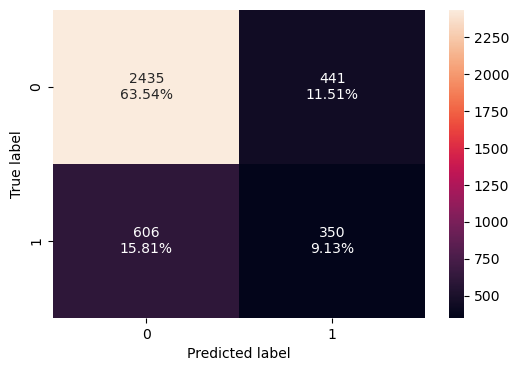

In [51]:

# creating confusion matrix
confusion_matrix_sklearn(log_reg_over, x_val, y_val)

- Performance on the training set improved but the model is not able to replicate the same for the validation set.
- Model is overfitting.
- Lets try:

a) Regularization to see if overfitting can be reduced

b) Undersampling the train to handle the imbalance between classes and check the model performance.

### Regularization

In [52]:
lr_estimator = LogisticRegression(random_state=1, solver='saga')
parameters = {"C": np.arange(0.1, 1.1,0.1)}

grid_obj = GridSearchCV(lr_estimator, parameters, scoring="recall")
grid_obj = grid_obj.fit(x_train_over, y_train_over)
lr_estimator = grid_obj.best_estimator_
lr_estimator.fit(x_train_over, y_train_over)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

LogisticRegression(C=0.1, random_state=1, solver='saga')

In [54]:
# Calculating different metrics on train set
log_reg_reg_train_perf = model_performance_classification_sklearn(
    lr_estimator, x_train_over, y_train_over
)
print("Training performance:")
log_reg_reg_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.730355,0.710709,0.739776,0.724951


In [55]:
# Calculating different metrics on validation set
log_reg_reg_val_perf = model_performance_classification_sklearn(
    lr_estimator, x_val, y_val
)
print("Validation performance:")
log_reg_reg_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.705376,0.588912,0.43341,0.499335


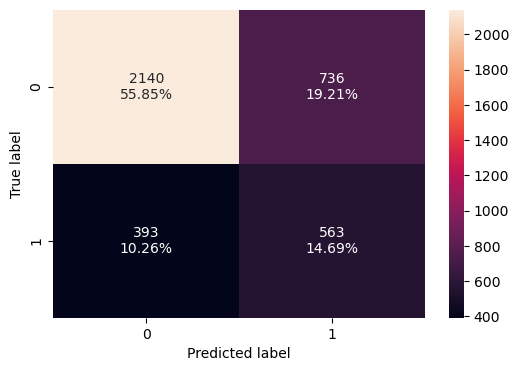

In [57]:
# creating confusion matrix
confusion_matrix_sklearn(lr_estimator, x_val, y_val)

### After regularization, overfitting has reduced to some extent.
Let's try undersampling now.

### Undersampling train data using Random Under Sampler

In [59]:
rus = RandomUnderSampler(random_state=1)
x_train_un, y_train_un = rus.fit_resample(x_train, y_train)

In [60]:
print("Before Undersampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After Undersampling, counts of label 'Yes': {}".format(sum(y_train_un == 1)))
print("After Undersampling, counts of label 'No': {} \n".format(sum(y_train_un == 0)))

print("After Undersampling, the shape of train_X: {}".format(x_train_un.shape))
print("After Undersampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Undersampling, counts of label 'Yes': 2866
Before Undersampling, counts of label 'No': 8628 

After Undersampling, counts of label 'Yes': 2866
After Undersampling, counts of label 'No': 2866 

After Undersampling, the shape of train_X: (5732, 56)
After Undersampling, the shape of train_y: (5732,) 



### Logistic Regression on undersampled data

In [61]:
log_reg_under = LogisticRegression(random_state=1)
log_reg_under.fit(x_train_un, y_train_un)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

### Let's check the model performance on train and validation set

In [62]:
# Calculating different metrics on train set
log_reg_under_train_perf = model_performance_classification_sklearn(
    log_reg_under, x_train_un, y_train_un
)
print("Training performance:")
log_reg_under_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.700977,0.682484,0.708696,0.695343


In [63]:
# Calculating different metrics on validation set
log_reg_under_val_perf = model_performance_classification_sklearn(
    log_reg_under, x_val, y_val
)
print("Validation performance:")
log_reg_under_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.714248,0.682008,0.451836,0.54356


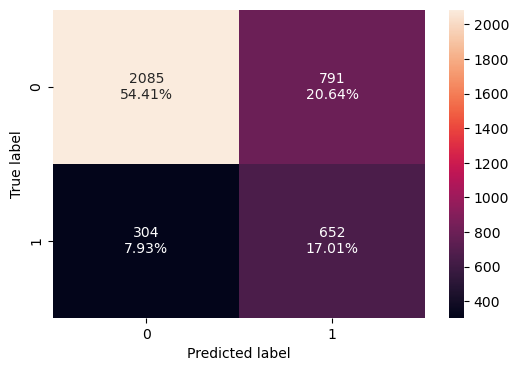

In [64]:
# creating confusion matrix
confusion_matrix_sklearn(log_reg_under, x_val, y_val)

- Model has given similar recall on training and validation set.
- Model performance has improved using undersampling.

In [65]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_over_train_perf.T,
        log_reg_reg_train_perf.T,
        log_reg_under_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression",
    "Logistic Regression with oversampled data",
    "Regularised Logistic Regression",
    "Logistic Regression with undersampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression,Logistic Regression with oversampled data,Regularised Logistic Regression,Logistic Regression with undersampled data
Accuracy,0.762137,0.806734,0.730355,0.700977
Recall,0.224006,0.768660,0.710709,0.682484
Precision,0.557292,0.832016,0.739776,0.708696
F1,0.319562,0.799084,0.724951,0.695343


In [66]:
# Validation performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_val_perf.T,
        log_reg_over_val_perf.T,
        log_reg_reg_val_perf.T,
        log_reg_under_val_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression",
    "Logistic Regression with oversampled data",
    "Regularised Logistic Regression",
    "Logistic Regression with undersampled data",
]
print("Validation performance comparison:")
models_train_comp_df

Validation performance comparison:


,Logistic Regression,Logistic Regression with oversampled data,Regularised Logistic Regression,Logistic Regression with undersampled data
Accuracy,0.761482,0.726775,0.705376,0.714248
Recall,0.245816,0.366109,0.588912,0.682008
Precision,0.549065,0.442478,0.433410,0.451836
F1,0.339595,0.400687,0.499335,0.543560


- Logistic regression model on undersampled data has given a better performance with the highest recall on validation data.

We can see that model tuned using undersampled data is best, let's check the performance of test data

In [67]:
# Calculating different metrics on validation set
log_reg_under_test_perf = model_performance_classification_sklearn(
    log_reg_under, x_test, y_test
)
print("Test performance:")
log_reg_under_test_perf

Test performance:


,Accuracy,Recall,Precision,F1
0,0.700678,0.67644,0.43531,0.529725


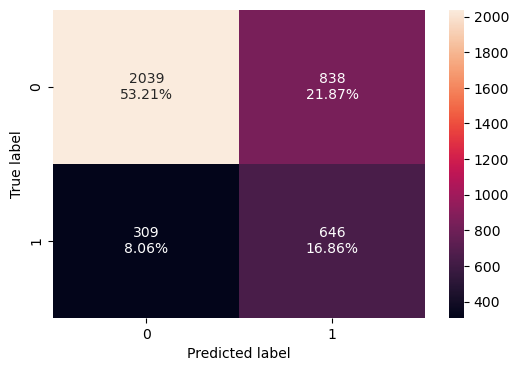

In [68]:
# creating confusion matrix
confusion_matrix_sklearn(log_reg_under, x_test, y_test)

Model trained with undersampled data has given ~68% recall on the test set.